In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("..")

In [3]:
os.environ['CUDA_VISIBLE_DEVICES']= '0'
os.environ['LIBRARY_PATH'] = '/usr/local/cuda/lib64'

In [4]:
from pyro import distributions as dist

In [5]:
# from model import YModel, OptLoss
# from gan import Generator, Discriminator, WSDiscriminator, GANLosses
# from metrics import Metrics
# from utils import sample_noise, iterate_minibatches, generate_data

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)


from collections import defaultdict
%matplotlib inline

In [12]:
import pyro
from pyro import distributions as dist
from pyro import poutine

def sample_noise(N, NOISE_DIM):
    return np.random.uniform(size=(N,NOISE_DIM)).astype(np.float32)

class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, hidden_dim=100, input_param=2):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(noise_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, z, params):
        """
            Generator takes a vector of noise and produces sample
        """
        #z = torch.cat([z, params.repeat(z.shape[0], 1)], dim=1)
        z = torch.cat([z, params], dim=1)
        h1 = torch.tanh(self.fc1(z))
        h2 = F.leaky_relu(self.fc2(h1))
        y_gen = self.fc3(h2)
        return y_gen
    
class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim=100, input_param=2):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(in_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)
        
        self.fc4 = nn.Linear(hidden_dim, 1)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.constant_(self.fc4.bias, 0.0)

    def forward(self, x, params):
        #x = torch.cat([x, params.repeat(x.shape[0], 1)], dim=1)
        x = torch.cat([x, params], dim=1)
        h1 = torch.tanh(self.fc1(x))
        h2 = F.leaky_relu(self.fc2(h1))
        h3 = F.leaky_relu(self.fc3(h2))
        score = torch.sigmoid(self.fc4(h3))
        return score
class YModel(object):
    def __init__(self, x_range=(-10,10), init_mu=torch.tensor(0.)):
        self.mu_dist = dist.Delta(init_mu)
        self.x_dist = dist.Uniform(*x_range)
        #self.x_dist = dist.Delta(torch.tensor(float(0)))
    @staticmethod
    def f(x, a=0, b=1, c=2):
        return a + b * x
    @staticmethod
    def g(x, d=2):
        #return -7 + x ** 2 / 10 + x ** 3 / 100
        #return d * torch.sin(x)
        return torch.sqrt(torch.sum(x ** 2, dim=1, keepdim=True))
        #return x
    
    def std_val(self, x):
        return 0.1 + torch.sqrt(torch.abs(x) * 0.5) ** 2
    
    def sample(self, sample_size=1):
        mu = pyro.sample('mu', self.mu_dist, torch.Size([sample_size]))
        if mu.size() == torch.Size([]):
            size = [1]
        else:
            size = mu.size()
        X = pyro.sample('X', self.x_dist, torch.Size(size))

        latent_x = pyro.sample('latent_x', dist.Normal(X, 1))
        latent_x = self.f(latent_x)

        latent_mu = self.g(mu)
        return pyro.sample('y', dist.Normal(latent_x + latent_mu, self.std_val(latent_x)))
        #return pyro.sample('y', dist.Normal(latent_x, 1)).float()
        #return pyro.sample('y', dist.Normal(latent_x, self.std_val(latent_x))).float()
    
    def make_condition_sample(self, data):
        self.condition_sample = poutine.condition(self.sample, data=data)
    
    def condition_sample(self, size=1):
        return self.condition_sample(size)

class OptLoss(object):
    def __init__(self):
        pass
    
    @staticmethod
    def R(ys: torch.tensor, Y_0=-5):
        return (ys - Y_0).pow(2).mean(dim=1)
    @staticmethod
    def SigmoidLoss(ys: torch.tensor, left_bound, right_bound):
        return -torch.mean(torch.sigmoid(ys - left_bound) - torch.sigmoid(ys - right_bound), dim=1)
    

In [6]:
import comet_ml

comet_api = comet_ml.papi.API()
comet_api.get()

['shir994']

In [7]:
def extract_metrics(exp, hyper_params, metrics, mask):
    for metric in exp.data['metrics']:
        metric_values = np.array(list(zip(*exp.metrics_raw[metric]))[1])
        metrics[metric].append([metric_values[mask], hyper_params['data_size']])

In [8]:
#mask = list(np.arange(0, 20)) + [50] + [100]
mask = list(np.arange(500))

In [190]:
# plt.figure(figsize=(12,6))
# plt.pcolormesh(range(0,30), sizes, data, cmap=my_cmap);
# plt.colorbar()
# plt.yscale("log")

In [18]:
# metrics = list(zip(*exp.metrics_raw["train_average_mu_JS"]))
# plt.plot(*metrics);

# Check model

In [11]:
exp = comet_api.get("shir994/2d-mu/f6432030afa64685b5df9497ec03bd9b")
hyper_params = {}
for param in exp.get_parameters_summary():
    hyper_params[param["name"]] = param["valueMin"]

In [13]:
TASK = int(hyper_params['TASK'])
NOISE_DIM = int(hyper_params["NOISE_DIM"])

In [15]:
generator = Generator(NOISE_DIM, out_dim = 1, input_param=3).to(device)
if TASK == 4:
    discriminator = WSDiscriminator(in_dim=1).to(device)
else:
    discriminator = Discriminator(in_dim=1, input_param=3).to(device)

y_sampler = YModel()
fixed_noise = torch.Tensor(sample_noise(10000, NOISE_DIM)).to(device)
#metric_calc = Metrics((-50, 50), 100)

In [16]:
import io

#asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == f"{hyper_params['data_size']}_999.tar"][0]
asset_id = [exp_a['assetId'] for exp_a in exp.get_asset_list() if exp_a['fileName'] == "2d_mu_mu_2d.tar"][0]
params = exp.get_asset(asset_id)
state_dict = torch.load(io.BytesIO(params))

In [17]:
state_dict.keys()

dict_keys(['gen_state_dict', 'dis_state_dict', 'genopt_state_dict', 'disopt_state_dict', 'epoch'])

In [18]:
generator.load_state_dict(state_dict['gen_state_dict'])

<All keys matched successfully>

In [12]:
# y_true = []
# y_gen = []
# for i in range(5000):
#     x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1]))
#     y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
#     y_true.append(y_sampler.condition_sample().mean().item())
#     noise = torch.Tensor(sample_noise(1000, NOISE_DIM)).to(device)
#     y_gen.append(generator(noise, torch.cat([mu.to(device), x_r.to(device)], dim=1)).mean().item())
# # plt.hist(y_sampler.condition_sample().mean(dim=1).cpu().numpy(), bins=100, density=True, label='true');
# # plt.hist(generator(fixed_noise, torch.cat([mu.to(device), x_r.to(device)], dim=1)).detach().cpu().numpy(),
# #          bins=100, color='g', density=True, alpha=0.5, label='gan');
# # plt.legend()

In [13]:
# plt.hist(y_true, bins=100, density=True, label='true');
# plt.hist(y_gen, bins=100, density=True, label='true');

In [22]:
# %%time
# my_cmap = plt.cm.jet
# my_cmap.set_under('white')
# mu_range = (-10,10)
# mu = dist.Uniform(*mu_range).sample([10000, 2]).to(device)

# y = np.zeros([len(mu), 1])

# for i in range(len(mu)):
#     noise = torch.Tensor(sample_noise(1000, NOISE_DIM)).to(device)
#     mu_r = mu[i, :].reshape(1,-1).repeat(1000, 1).to(device)
#     x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
#     y[i, 0] = generator(noise, torch.cat([mu_r,x_r],dim=1)).mean().item()

In [23]:
# plt.figure(figsize=(12,6))
# mu = mu.cpu().numpy()
# plt.scatter(mu[:,0], mu[:, 1], c=y[:,0], cmap=my_cmap)
# cbar = plt.colorbar()

# plt.xlabel(f"$\psi_1$", fontsize=19)
# plt.ylabel(f"$\psi_2$", fontsize=19)
# cbar.set_label('y', rotation=360, fontsize=19)
# plt.show()

In [21]:
# mu = dist.Uniform(-10,10).sample([10000, 2])
# x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
# y_sampler.make_condition_sample({'mu': mu, 'X': x_r})

# y = y_sampler.condition_sample()
# y_mean = y.mean(dim=1)

# plt.figure(figsize=(12,6))
# plt.scatter(mu[:,0], mu[:, 1], c=y_mean, cmap=my_cmap)
# cbar = plt.colorbar()

# plt.xlabel(f"$\psi_1$", fontsize=19)
# plt.ylabel(f"$\psi_2$", fontsize=19)
# cbar.set_label('y', rotation=360, fontsize=19)
# plt.show()

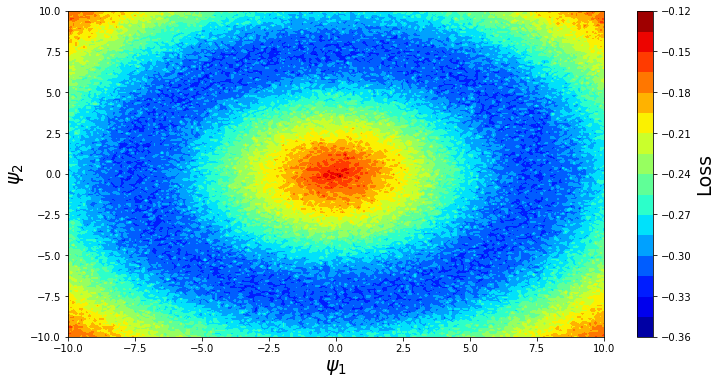

In [55]:
from itertools import product
x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
mu = torch.tensor(np.array(list(product(x,y)))).float()
y_sampler = YModel()

noise_size = 1000

import numpy as np
plt.figure(figsize=(12,6))
#mu = dist.Uniform(-10,10).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, 5, 10)

#plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
plt.contourf(*np.meshgrid(x,y), torch.transpose(rs.reshape(-1, x.shape[0]), 1,0), cmap=my_cmap, levels=15)

cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)

In [25]:
%%time

loss_val = np.zeros([len(mu), 1])
for i in range(len(mu)):
    noise = torch.Tensor(sample_noise(noise_size, NOISE_DIM)).to(device)
    mu_r = mu[i, :].reshape(1,-1).repeat(noise_size, 1).to(device)
    x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
    samples = generator(noise, torch.cat([mu_r,x_r],dim=1))
    loss_val[i, 0] = OptLoss.SigmoidLoss(samples, 5, 10).mean().item()

CPU times: user 45.5 s, sys: 520 ms, total: 46 s
Wall time: 46.1 s


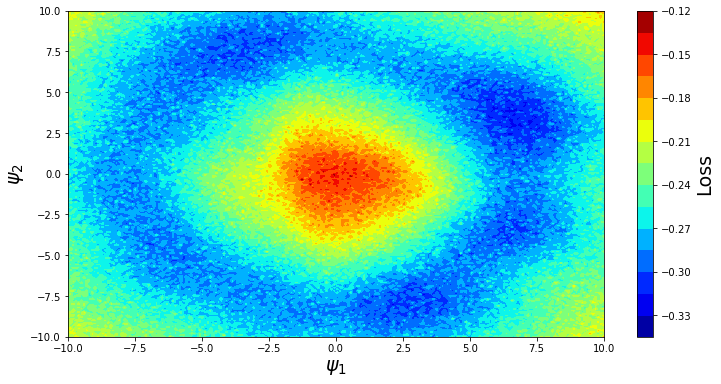

In [27]:
plt.figure(figsize=(12, 6))

plt.contourf(*np.meshgrid(x,y), loss_val.reshape(-1, x.shape[0]).T, cmap=my_cmap, levels=15)
cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)     

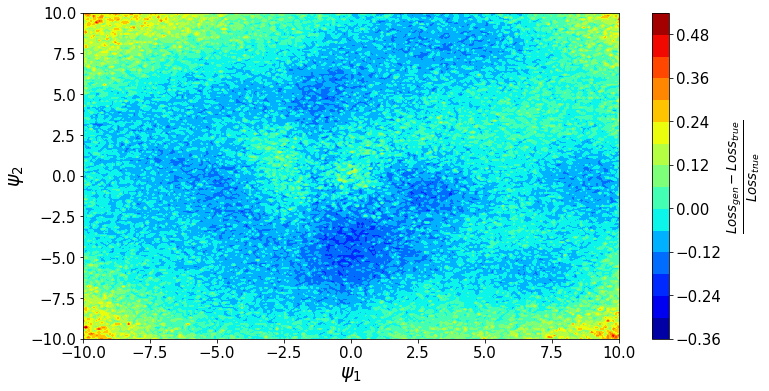

In [33]:
plt.figure(figsize=(12, 6))

plt.contourf(*np.meshgrid(x,y), 
             (loss_val.reshape(-1, x.shape[0]).T - np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0)))/
             np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0)),
             cmap=my_cmap, levels=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$\frac{Loss_{gen} - Loss_{true}}{Loss_{true}}$', rotation=90, fontsize=19) 
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
plt.gca().tick_params(axis="both", labelsize=15)

In [28]:
# %%time
# plt.figure(figsize=(12,6))
# mu_range = (-10,10)
# mu = dist.Uniform(*mu_range).sample([10000, 2]).to(device)

# y = np.zeros([len(mu), 1])

# rs = []
# for i in range(len(mu)):
#     noise = torch.Tensor(sample_noise(1000, NOISE_DIM)).to(device)
#     mu_r = mu[i, :].reshape(1,-1).repeat(1000, 1).to(device)
#     x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
#     samples = generator(noise, torch.cat([mu_r,x_r],dim=1))
#     rs.append(OptLoss.SigmoidLoss(samples, 5, 10).mean().item())

# mu = mu.cpu().numpy()
# plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
# cbar = plt.colorbar()
# plt.xlabel(f"$\psi_1$", fontsize=19)
# plt.ylabel(f"$\psi_2$", fontsize=19)
# cbar.set_label('Loss', rotation=90, fontsize=19)

In [29]:
# import numpy as np
# plt.figure(figsize=(12,6))
# mu = dist.Uniform(-10,10).sample([10000, 2])
# x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
# y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
# samples = y_sampler.condition_sample()
# rs = OptLoss.SigmoidLoss(samples, 5, 10)

# plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
# cbar = plt.colorbar()
# plt.xlabel(f"$\psi_1$", fontsize=19)
# plt.ylabel(f"$\psi_2$", fontsize=19)
# cbar.set_label('Loss', rotation=90, fontsize=19)

# Test optimisation

In [34]:
from copy import deepcopy

class InputOptimisation(nn.Module):
    def __init__(self, generator_model):
        super().__init__()
        self.gen = deepcopy(generator_model)
        for param in self.gen.parameters():
            param.requires_grad = False
        self.gen.eval()
       
    def forward(self, noise, inputs):
        return self.gen(noise, inputs)
    
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')    

In [42]:
io_model = InputOptimisation(generator)

lr = 10
average_size = 1000

mu_optim = torch.tensor([-1.,-1.]).reshape(1,-1)
mu_optim = mu_optim.repeat(average_size, 1).to(device)
mu_optim.requires_grad=True

In [43]:
%%time
n_iter = 100000
losses = []
m_vals = []
for _iter in range(n_iter):
    noise = torch.Tensor(sample_noise(average_size, NOISE_DIM)).to(device)
    x = y_sampler.x_dist.sample([average_size, 1]).to(device)
    # Do an update
    data_gen = io_model(noise, torch.cat([mu_optim, x], dim=1))
    loss = OptLoss.SigmoidLoss(data_gen, 5, 10).mean()
    losses.append(loss.item())
    io_model.zero_grad()
    loss.backward()
    with torch.no_grad():
        mu_optim -= lr * mu_optim.grad.mean(dim=0, keepdim=True)
        mu_optim.grad.zero_()
    m_vals.append(mu_optim[0].detach().cpu().numpy())
m_vals =np.array(m_vals)    

CPU times: user 2min 51s, sys: 8.19 s, total: 2min 59s
Wall time: 3min 1s


In [45]:
import pandas as pd

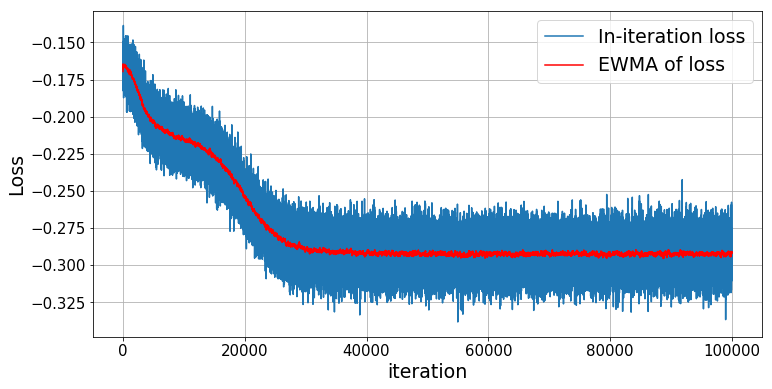

In [53]:
plt.figure(figsize=(12,6))


plt.plot(losses, label='In-iteration loss');
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iteration", fontsize=19)
plt.plot(pd.Series(losses).ewm(span=150).mean().tolist(), c='r', label='EWMA of loss')
plt.legend(fontsize=19)
plt.gca().tick_params(axis="both", labelsize=15)

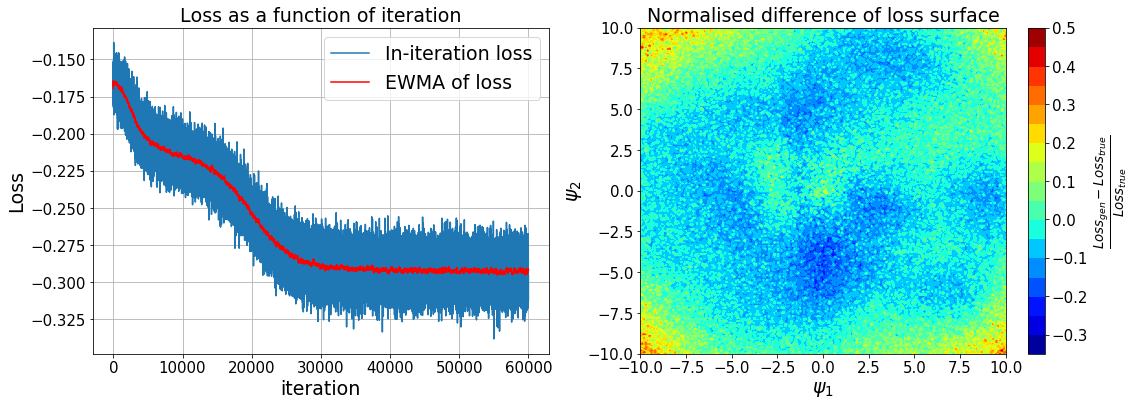

In [65]:
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)

plt.plot(losses[:60000], label='In-iteration loss');
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iteration", fontsize=19)
plt.plot(pd.Series(losses[:60000]).ewm(span=150).mean().tolist(), c='r', label='EWMA of loss')
plt.legend(fontsize=19)
plt.gca().tick_params(axis="both", labelsize=15)
plt.title("Loss as a function of iteration", fontsize=19)

plt.subplot(1,2,2)
plt.contourf(*np.meshgrid(x,y), 
             (loss_val.reshape(-1, x.shape[0]).T - np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0)))/
             np.array(torch.transpose(rs.reshape(-1, x.shape[0]), 1,0)),
             cmap=my_cmap, levels=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$\frac{Loss_{gen} - Loss_{true}}{Loss_{true}}$', rotation=90, fontsize=19) 
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
plt.gca().tick_params(axis="both", labelsize=15)
plt.title("Normalised difference of loss surface", fontsize=19)
plt.savefig("2d_gso_opt.pdf", bbox_inches='tight')

Text(0.5, 0, 'iter')

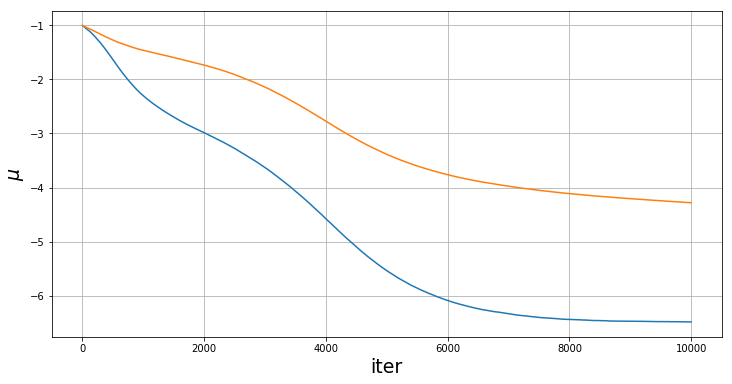

In [49]:
plt.figure(figsize=(12,6))
plt.plot(m_vals[:,0]);
plt.plot(m_vals[:,1]);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)

In [44]:
def find_mu(init_mu, n_iter=100000):
    io_model = InputOptimisation(generator)
    mu_optim = torch.tensor(init_mu).reshape(1,-1)
    mu_optim = mu_optim.repeat([average_size, 1]).to(device)
    mu_optim.requires_grad=True
    #losses = []
    m_vals = []
    lr = 50.
    for _iter in range(n_iter):
        noise = torch.Tensor(sample_noise(average_size, NOISE_DIM)).to(device)
        x = y_sampler.x_dist.sample([average_size, 1]).to(device)
        # Do an update
        data_gen = io_model(noise, torch.cat([mu_optim, x], dim=1))
        loss = OptLoss.SigmoidLoss(data_gen, 5, 10).mean()
        #losses.append(loss.item())
        io_model.zero_grad()
        loss.backward()
        with torch.no_grad():
            mu_optim -= lr * mu_optim.grad.mean(dim=0, keepdim=True)
            mu_optim.grad.zero_()
        m_vals.append(mu_optim[0].detach().cpu().numpy())
    return m_vals

In [69]:
various_restarts = []
for _ in range(10):
    opt_mu = []
    for mu in [[0.,0.], [0., 2.], [0., -2.], [2., 0.], [10., 10.], [-10., 0.], [0., 7.], [0., 10.]]:
        opt_mu.append(find_mu(mu, n_iter=10000))
    various_restarts.append(opt_mu)

In [ ]:
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals))

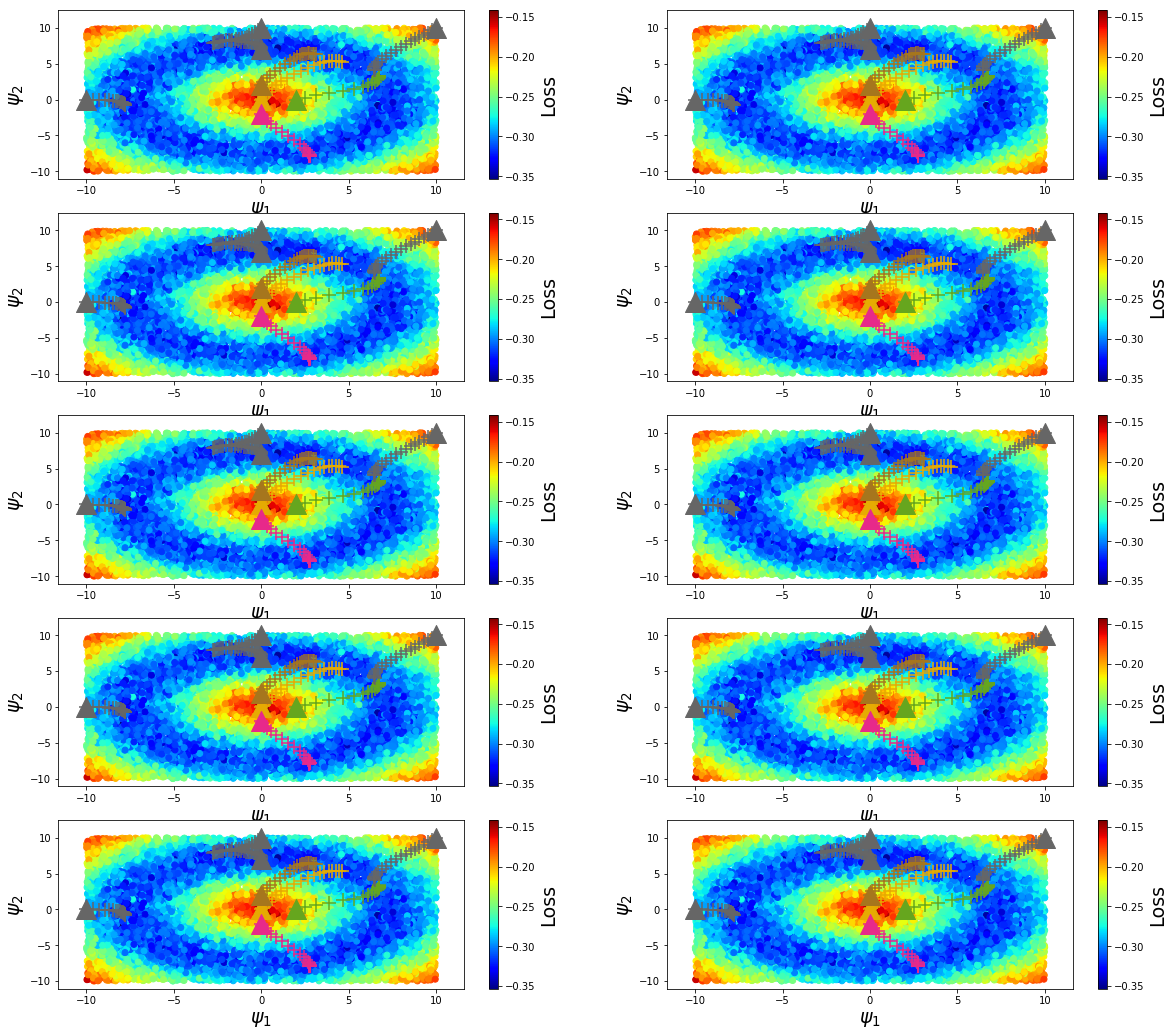

In [74]:
plt.figure(figsize=(20, 18))

mu = dist.Uniform(-10,10).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, 5, 10)

for _index in range(10):
    plt.subplot(5,2,_index + 1)

    plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
    cbar = plt.colorbar()
    plt.xlabel(f"$\psi_1$", fontsize=19)
    plt.ylabel(f"$\psi_2$", fontsize=19)
    cbar.set_label('Loss', rotation=90, fontsize=19)

    
    opt_mu = various_restarts[index]
    for index, mu_path in enumerate(opt_mu):
        mus = np.array(mu_path)
        plt.scatter(mus[0, 0], mus[0, 1], c=np.array(cmap(index)).reshape(1, -1), marker='^', s=400)
        plt.scatter(mus[::500, 0], mus[::500, 1], c=np.array(cmap(index)).reshape(1, -1), marker='+', s=200)
plt.savefig("plots/path_restarts.pdf", bbox_inches='tight')        

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

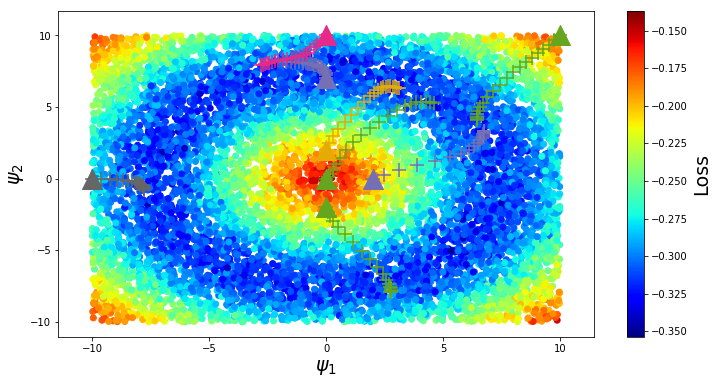

In [128]:
plt.figure(figsize=(12,6))
mu = dist.Uniform(-10,10).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, 5, 10)

plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)


for index, mu_path in enumerate(opt_mu):
    mus = np.array(mu_path)
    plt.scatter(mus[0, 0], mus[0, 1], c=cmap(index), marker='^', s=400)
    plt.scatter(mus[::500, 0], mus[::500, 1], c=cmap(index), marker='+', s=200)
    plt.grid()
    plt.grid()